In [1]:
# Colab setup: install utilities (if needed) and import libraries
!pip install -q scikit-learn plotly kaggle

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns, plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 0: Setup Kaggle API
from google.colab import files
files.upload()  # Upload kaggle.json file from your system

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Step 0.1: Download Pima Indians Diabetes Dataset
!kaggle datasets download -d uciml/pima-indians-diabetes-database

# Step 0.2: Unzip the dataset
!unzip pima-indians-diabetes-database.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 42.9MB/s]
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [3]:
# Step 2: Load dataset
df = pd.read_csv("diabetes.csv")

# Basic info
print(df.shape)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())


(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479  

In [4]:
# Step 3: Remove duplicates if any
df = df.drop_duplicates()

# Replace zeros in certain columns with NaN (since they can't be zero in reality)
cols_with_zero_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_nan] = df[cols_with_zero_nan].replace(0, np.nan)

# Impute missing values
for col in cols_with_zero_nan:
    df[col] = df[col].fillna(df[col].median())


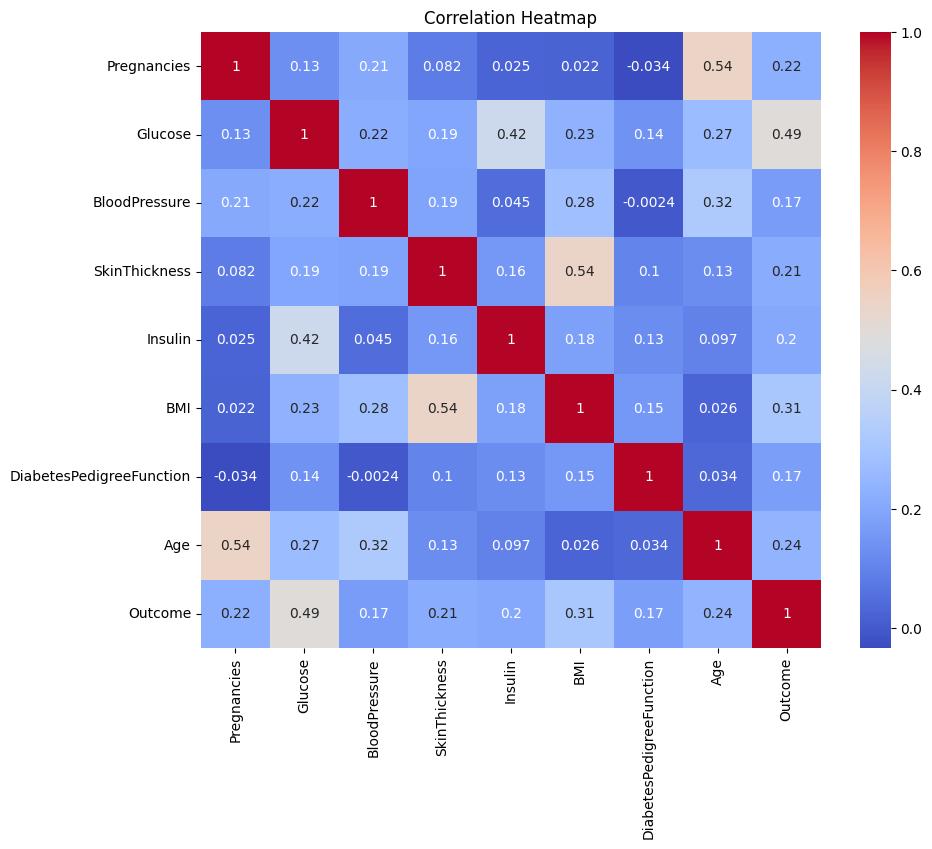

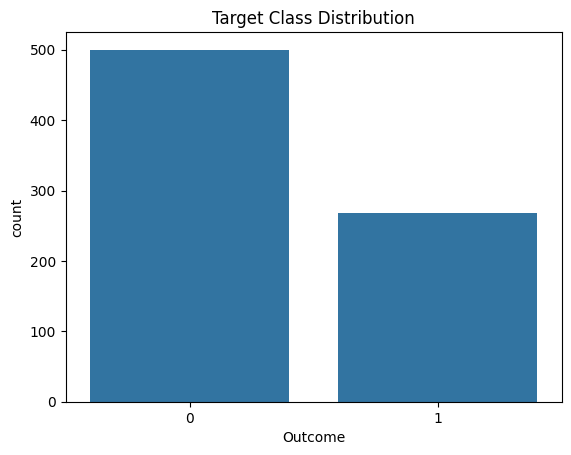

In [5]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Class distribution
sns.countplot(data=df, x="Outcome")
plt.title("Target Class Distribution")
plt.show()


In [6]:
# Step 5: Features and Target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing: Scale numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns)
    ]
)


In [7]:
# Step 6: Build pipelines for each model
pipe_knn = Pipeline([('pre', preprocessor), ('clf', KNeighborsClassifier())])
pipe_dt = Pipeline([('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])

# Train & Evaluate
models = {"KNN": pipe_knn, "DecisionTree": pipe_dt, "RandomForest": pipe_rf}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



KNN Results:
Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154


DecisionTree Results:
Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154


RandomForest Results:
Accuracy: 0.7792207792207793
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.61      0.66        54

    accuracy                       

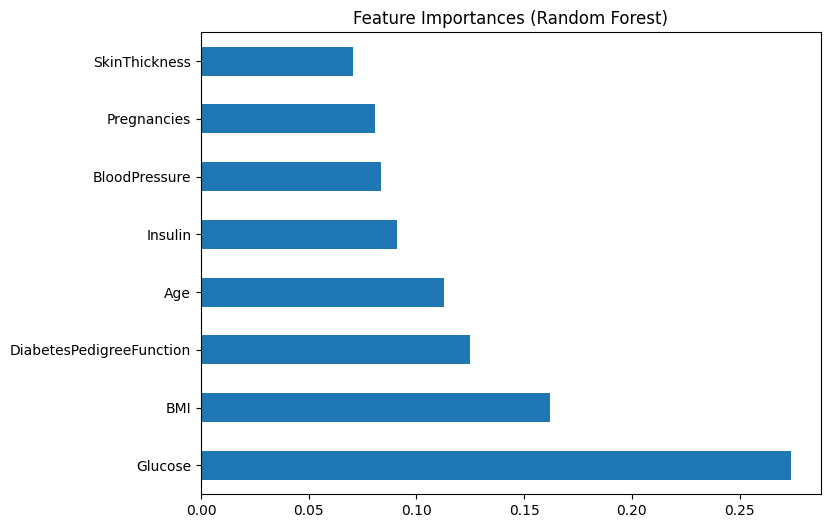

In [8]:
pipe_rf.fit(X_train, y_train)
rf_clf = pipe_rf.named_steps['clf']
feat_imp = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.show()


In [9]:
# Random Forest tuning
from scipy.stats import randint

param_dist = {
    'clf__n_estimators': randint(50,200),
    'clf__max_depth': randint(2,20),
    'clf__min_samples_split': randint(2,20)
}

rs_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=20,
                           scoring='f1', cv=5, random_state=42, n_jobs=-1)
rs_rf.fit(X_train, y_train)
print("Best Parameters:", rs_rf.best_params_)

best_rf = rs_rf.best_estimator_


Best Parameters: {'clf__max_depth': 9, 'clf__min_samples_split': 8, 'clf__n_estimators': 171}


Accuracy: 0.7662337662337663
Precision: 0.6875
Recall: 0.6111111111111112
F1 Score: 0.6470588235294118

Confusion Matrix:
 [[85 15]
 [21 33]]


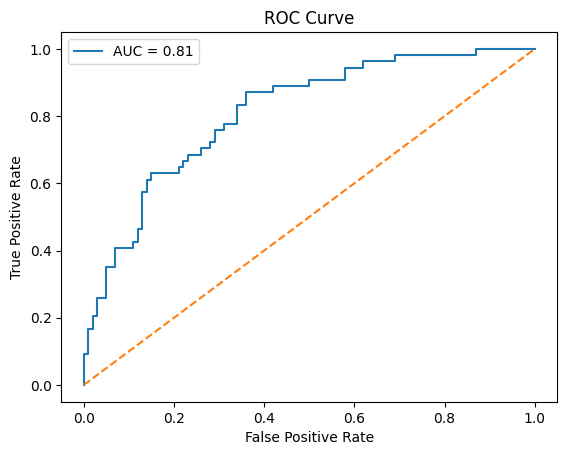

In [10]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
